In [1]:
import pickle as pkl
import numpy as np
import healpy as hp
import pylab as pl
import camb
from scipy import stats,optimize
import sys
import os
#sys.path.append('../gaia-quasars-lss/code')
#from lensing_qso_cross_utils import get_custom_binning,define_binning
import pymaster as nmt
import astropy.constants as const
from scipy import interpolate
from bins import Bins

In the notebook I compare the theory prediction between CCL and CAMB. I focus in particular on 2 factors:
1) Limber approximation
2) Differences in implementation of the correction

I will follow the notebook available here for CCL https://github.com/LSSTDESC/CCLX/blob/master/GeneralizedTracers.ipynb where
 
 $$ \Delta b = (b-1)f_{NL}\frac{3\delta_c\Omega_m H_0^2}{D(a)k^2}$$

I will refere to this formula at CCL T(k) in the plot labels.

Other paper in the literature (https://arxiv.org/pdf/1702.05088) wrote the the correction differently and that's what I also implemented for the CAMB case as a reference (though for the purpose of comparison I also implemented the previous formula).

$$ \Delta b = (b-1)f_{NL}\frac{3\delta_c\Omega_m H_0^2}{D(a)T(k)k^2}$$

where T(k) should be normalized to 1 at large scales. 

### Note 1
Both the D functions should have an extra normalization to normalize the growth rate to $1/(1+z)$ in matter domination so the most generalized formula should read 

$$ \Delta b = (b-1)f_{NL}\frac{3\delta_c\Omega_m H_0^2}{D(z)T(k)k^2}\frac{g(\infty)}{g(0)}$$

where $g(z)=(1+z)D(z)$. This account for an extra factor of 1.3 in the numerator (or D(z) multiplied by ~0.77). Both formula shoudl be corrected by this  number but I neglected this for the time being. 

### Note 2 

It's not trivial to switch off the beyond Limber correction to the cross-correlation in CAMB.

In [2]:
nside = 16
nside_hr = 256
dell = 2 #binning
lmin = 2 # doesn't matter as code forces lmin=2 and cls assum l_0=l_1=0.
lmax = 3 * nside - 1
lmax_hr = 3 * nside_hr -1
def get_binning_custom():
    lmins = np.arange(2,40,2)
    lmins = np.append(lmins,np.arange(40,60,5))
    lmins = np.append(lmins,np.arange(60,767,30))

    lmaxs = np.arange(4,42,2)
    lmaxs = np.append(lmaxs,np.arange(45,65,5))
    lmaxs = np.append(lmaxs,np.arange(90,767,30))
    lmaxs = np.append(lmaxs,767)
    return lmins,lmaxs

lmins,lmaxs = get_binning_custom()
bins_nmt= nmt.NmtBin.from_edges(lmins, lmaxs, is_Dell=False)
binning = bins_nmt

In [3]:
dndz = np.loadtxt('dndz_zerr_20230406.dat',unpack=True)
z_W=np.array(dndz[0])
W=np.array(dndz[1])

bz_qso_th_positive = np.array([[0.50,1.32 ,0.17 ],[1.13 ,2.31 ,0.22],[1.68,2.96 ,0.26 ],[2.18,4.69 ,0.70 ],
                               [3.17,7.76 ,1.44 ],[3.84,12.96,2.09 ]])
bz_qso_th = np.array([[0.50,1.32,0.17 ],[1.13 ,2.20,0.23 ],[1.68 ,2.49,0.27 ],[2.18 ,3.29,0.79 ],
                      [3.17,7.10,1.48],[3.84,9.85,2.27]])

#bz_sdss = interpolate.interp1d(bz_qso_th[:,0],bz_qso_th[:,1],fill_value=(0.,0.),bounds_error=False)
bz_sdss = interpolate.interp1d(bz_qso_th[:,0],bz_qso_th[:,1],fill_value='extrapolate',bounds_error=False)



# Laurent+2017 notice last bin is the effective one https://arxiv.org/pdf/1705.04718.pdf
bz_qso_laurent = np.array([[1.06,1.75, 0.08],[1.35,2.06, 0.08],[1.65,2.57, 0.09],
                           [1.99,3.03, 0.11],[1.55,2.43, 0.05]])

bz_laurent = interpolate.interp1d(bz_qso_laurent[:,0],bz_qso_laurent[:,1],fill_value='extrapolate',bounds_error=False)


# Photometric model in agreement with Sherwin+2012 and Leisted+2015
def bz_sdss_photo(z):
    return 1+((1+z)/2.5)**5

def bz_desi(z):
    return 0.278*((1+z)**2-6.565)+2.393

b_z = 0.278*((1+z_W)**2-6.565)+2.393

# CAMB

In [5]:
# Cosmology definition 
h0=0.67
Ob = 0.0492071330589849
Odm= 0.2619039780521262
As=np.e**3.047/1e10
ns = 0.9665

In [6]:
from camb import model, initialpower
import camb
from camb.sources import GaussianSourceWindow, SplinedSourceWindow


def init_pars(lmin_limber=1,do_magnification_bias=0.,do_cmb = False, do_transfer=True):

    pars = camb.CAMBparams()
    lmax=1000#3*256-1
    print(lmin_limber)
    pars.set_cosmology(H0=h0*100, ombh2=Ob*h0**2, omch2=Odm*h0**2, mnu=0,tau=0.0561)
    pars = camb.set_params(H0=h0*100, ombh2=Ob*h0**2, omch2=Odm*h0**2, mnu=0,tau=0.0561,halofit_version='takahashi')
    #As = np.e**3.047/1e10
    pars.InitPower.set_params(As=As, ns=ns)
    pars.set_for_lmax(lmax, lens_potential_accuracy=2)
    
    ##set Want_CMB to true if you also want CMB spectra or correlations
    pars.Want_CMB = do_cmb
    pars.Want_transfer = do_transfer
    ##NonLinear_both or NonLinear_lens will use non-linear corrections
    pars.NonLinear = model.NonLinear_both
    
    #pars.NonLinear = model.NonLinear_none

    #density only is the default
    pars.SourceTerms.limber_windows = True
    pars.SourceTerms.limber_phi_lmin = lmin_limber
    if do_magnification_bias>0:
        pars.SourceTerms.counts_lensing = False  # force to avoid confusion
    else:
        pars.SourceTerms.counts_lensing = False

    pars.SourceTerms.counts_density  = True
    pars.SourceTerms.counts_redshift = False #weird problems at times
    pars.SourceTerms.counts_radial   = False # negligible at l<10
    pars.SourceTerms.counts_timedelay = False # negligible
    pars.SourceTerms.counts_ISW = False #negligible
    pars.SourceTerms.counts_velocity = False #negligible
    pars.SourceTerms.counts_potential = False #negligible
    pars.SourceTerms.counts_evolve = False # not sure what this is
    
    pars.Accuracy.LensingBoost = 1.0
    pars.Accuracy.NonlinSourceBoost = 1.0
    pars.Accuracy.BesselBoost = 1.0
    pars.Accuracy.LimberBoost = 1.0
    pars.Accuracy.SourceLimberBoost = 2.0
    pars.Accuracy.SourcekAccuracyBoost=2.
    return pars


In [7]:
nz = 150 #number of steps to use for the radial/redshift integration
kmax=1000  #kmax to use

#First set up parameters as usual
pars = init_pars(do_cmb=True)

results_bg= camb.get_background(pars)
chistar = results_bg.conformal_time(0)- results_bg.tau_maxvis
chis = np.linspace(0,chistar,nz)
zs=results_bg.redshift_at_comoving_radial_distance(chis)
pars.set_matter_power(redshifts=zs, kmax=kmax)
results= camb.get_results(pars)
trans = results.get_matter_transfer_data()

#k_trans = get kh - the values of k/h at which they are calculated and convert to k
kh = trans.transfer_data[0,:,-1] # note earliest redshift first
k = kh/pars.h
delta = trans.transfer_data[model.Transfer_tot-1,:,-1]
delta = np.interp(kh/pars.h,kh,delta)

Tk = interpolate.interp1d(k,delta/delta[0],fill_value='extrapolate',bounds_error=False)
Dz = interpolate.interp1d(zs,results.get_sigma8()[::-1]/results.get_sigma8_0(),fill_value='extrapolate',bounds_error=False)

def Om(z):
    #Om = (pars.omnuh2+pars.omch2+pars.ombh2)/pars.h**2
    return results.get_Omega('nu',z)+results.get_Omega('baryon',z)+results.get_Omega('cdm',z)

delta_c = 1.686
c = const.c.to('km/s').value

def bz_constant(z):
    if type(z) == np.ndarray:
        b_g_z=np.ones_like(z)
    else:
        b_g_z=1.
    return b_g_z

def b_g(z,bz_model=bz_sdss):
    b_g_z = bz_model(z)
    if type(z) == np.ndarray:
        b_g_z[b_g_z<1.]=1.
    else:
        if b_g_z<1:
            b_g_z=1.
    return b_g_z

def b_phi(z,bz_model=bz_desi,bg_model_rescaling=1,bphi_shift=1):
    return delta_c*(b_g(z,bz_model)*bg_model_rescaling - bphi_shift)

def db_g(z,k,fNL=1.,z_pivot=0,bz_model=bz_desi,bg_model_rescaling=1):
    # results.h_of_z gives H0(z)/c 
    return fNL*3*Om(z_pivot)*(results.h_of_z(z_pivot))**2*b_phi(z,bz_model,bg_model_rescaling=bg_model_rescaling)/(Dz(z)*Tk(k)*k**2)

def b_h(z,k,fNL=1,z_pivot=0,bz_model=bz_desi,bg_model_rescaling=1):
    b_h = bg_model_rescaling*b_g(z,bz_model)+db_g(z,k,fNL,z_pivot,bz_model,bg_model_rescaling)
    return b_h

# Removes transfer function to match the definition of the CCL example 

def db_g_ccl(z,k,fNL=1.,z_pivot=0,bz_model=bz_desi,bg_model_rescaling=1):
    # results.h_of_z gives H0(z)/c 
    return fNL*3*Om(z_pivot)*(results.h_of_z(z_pivot))**2*b_phi(z,bz_model,bg_model_rescaling=bg_model_rescaling)/(Dz(z)*k**2)

def b_h_ccl(z,k,fNL=1,z_pivot=0,bz_model=bz_desi,bg_model_rescaling=1):
    b_h = bg_model_rescaling*b_g(z,bz_model)+db_g_ccl(z,k,fNL,z_pivot,bz_model,bg_model_rescaling)
    return b_h

1
Note: redshifts have been re-sorted (earliest first)


In [8]:
zs[-1]

1088.723631751661

In [13]:
def get_theory_cl(bias_func,dndz,fNL_th=0.,bz_model=bz_desi,bg_model_rescaling=1,do_magnification=0.39,lmax_th = binning.lmax,lmin_limber=100):
    
    pars_nolimber = init_pars(lmin_limber=lmin_limber,do_magnification_bias=do_magnification,do_cmb=False,do_transfer=False) 
    
    
    zs_p = np.array(dndz[0]) #zs[zs<=dndz[0][-1]]
    ks = np.logspace(-6, 3, len(zs_p))
    bias_kz = np.ones((len(ks), len(zs_p)))
    
    for _i,z_i in enumerate(zs_p):
        bias_kz[:,_i] = bias_func(z_i,ks,fNL=fNL_th,z_pivot=0,bz_model=bz_model,bg_model_rescaling=bg_model_rescaling)
        
    W = np.array(dndz[1])
    
    if fNL_th==0:
        pars_nolimber.SourceWindows = [SplinedSourceWindow(k_bias=ks, bias_kz=bias_kz, z=zs_p, W=W,source_type='counts',dlog10Ndm = do_magnification), \
                                       SplinedSourceWindow(bias_z=bz_model(zs_p), z=zs_p, W=W,source_type='counts',dlog10Ndm = do_magnification)]
    else:
        pars_nolimber.SourceWindows = [SplinedSourceWindow(k_bias=ks, bias_kz=bias_kz, z=zs_p, W=W,source_type='counts',dlog10Ndm = do_magnification)]
        
    results_nolimber = camb.get_results(pars_nolimber)
    cls_nolimber = results_nolimber.get_source_cls_dict(raw_cl=True)        

    l_camb = np.arange(len(cls_nolimber["W1xW1"]))
    p2k= l_camb*(l_camb+1)/2    
    
    cl_gg_th = cls_nolimber['W1xW1']
    cl_kg_th = cls_nolimber['W1xP']*p2k
    cl_kk_th = cls_nolimber['PxP']*p2k**2
    if fNL_th==0:
        cl_gg_th_nok = cls_nolimber['W2xW2']
        cl_kg_th_nok = cls_nolimber['W2xP']*p2k
        return l_camb[:lmax_th+1],cl_kg_th[:lmax_th+1], cl_gg_th[:lmax_th+1],cl_kk_th[:lmax_th+1],cl_gg_th_nok[:lmax_th+1],cl_kg_th_nok[:lmax_th+1]
    else:
        return l_camb[:lmax_th+1],cl_kg_th[:lmax_th+1], cl_gg_th[:lmax_th+1],cl_kk_th[:lmax_th+1]

In [14]:
# defines same z range as done for later in CCL
zint = np.linspace(0,5,1024)

fNL=0.
cls_th = get_theory_cl(b_h,[zint,np.interp(zint,dndz[0],dndz[1])],fNL_th=fNL,bz_model=bz_desi,do_magnification=-1,lmax_th=1000)
cls_th_lim = get_theory_cl(b_h,[zint,np.interp(zint,dndz[0],dndz[1])],fNL_th=fNL,bz_model=bz_desi,do_magnification=-1,lmax_th=1000,lmin_limber=1)

fNL=20.
cls_th_fnl = get_theory_cl(b_h,[zint,np.interp(zint,dndz[0],dndz[1])],fNL_th=fNL,bz_model=bz_desi,do_magnification=-1,lmax_th=1000)
cls_th_fnl_ccl = get_theory_cl(b_h_ccl,[zint,np.interp(zint,dndz[0],dndz[1])],fNL_th=fNL,bz_model=bz_desi,do_magnification=-1,lmax_th=1000)
cls_th_fnl_lim = get_theory_cl(b_h,[zint,np.interp(zint,dndz[0],dndz[1])],fNL_th=fNL,bz_model=bz_desi,do_magnification=-1,lmax_th=1000,lmin_limber=1)
cls_th_fnl_ccl_lim = get_theory_cl(b_h_ccl,[zint,np.interp(zint,dndz[0],dndz[1])],fNL_th=fNL,bz_model=bz_desi,do_magnification=-1,lmax_th=1000,lmin_limber=1)

100
1
100
100
1
1


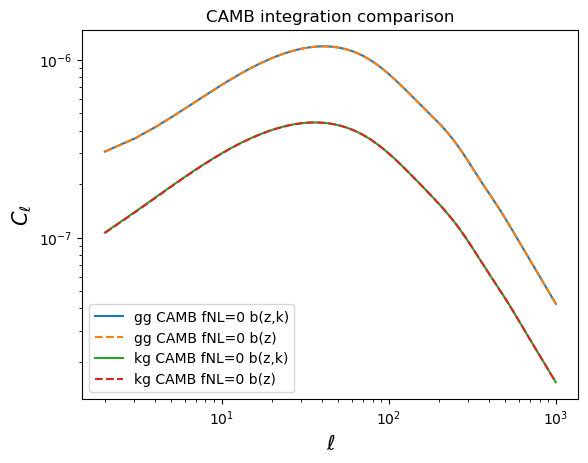

In [15]:
pl.loglog(cls_th[0][2:],cls_th_lim[2][2:],label='gg CAMB fNL=0 b(z,k)')
pl.loglog(cls_th[0][2:],cls_th_lim[4][2:],ls='--',label='gg CAMB fNL=0 b(z)')

pl.loglog(cls_th[0][2:],cls_th_lim[1][2:],label='kg CAMB fNL=0 b(z,k)')
pl.loglog(cls_th[0][2:],cls_th_lim[5][2:],ls='--',label='kg CAMB fNL=0 b(z)')
pl.ylabel("$C_\\ell$",size=15)
pl.xlabel('$\\ell$',size=15)
pl.legend()
pl.title("CAMB integration comparison")
pl.show()

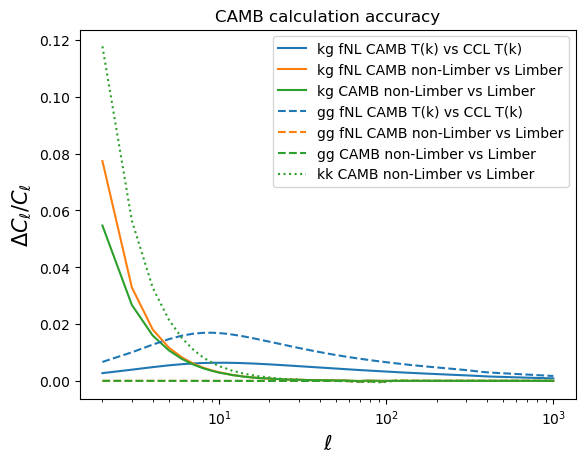

In [16]:
pl.plot(cls_th_fnl[0][2:],cls_th_fnl[1][2:]/cls_th_fnl_ccl[1][2:] -1,label='kg fNL CAMB T(k) vs CCL T(k)')
pl.plot(cls_th_fnl[0][2:],cls_th_fnl[1][2:]/cls_th_fnl_lim[1][2:] -1,label='kg fNL CAMB non-Limber vs Limber')
pl.plot(cls_th_fnl[0][2:],cls_th[1][2:]/cls_th_lim[1][2:] -1,label='kg CAMB non-Limber vs Limber')

pl.plot(cls_th_fnl[0][2:],cls_th_fnl[2][2:]/cls_th_fnl_ccl[2][2:] -1,color='C0',ls='--',label='gg fNL CAMB T(k) vs CCL T(k)')
pl.plot(cls_th_fnl[0][2:],cls_th_fnl[2][2:]/cls_th_fnl_lim[2][2:] -1,color='C1',ls='--',label='gg fNL CAMB non-Limber vs Limber')
pl.plot(cls_th_fnl[0][2:],cls_th[2][2:]/cls_th_lim[2][2:] -1,color='C2',ls='--',label='gg CAMB non-Limber vs Limber')

pl.plot(cls_th_fnl[0][2:],cls_th_fnl[3][2:]/cls_th_fnl_lim[3][2:] -1,color='C2',ls=':',label='kk CAMB non-Limber vs Limber')
#pl.plot(cls_th_fnl[0][2:],cls_th[3][2:]/cls_th_lim[3][2:] -1,color='C3',ls=':')

#pl.yscale('log')
pl.xscale('log')
pl.ylabel("$\\Delta C_\\ell/C_\\ell$",size=15)
pl.xlabel('$\\ell$',size=15)
pl.legend()
pl.title("CAMB calculation accuracy")
pl.show()

# CCL

In [11]:
import pyccl as ccl

ModuleNotFoundError: No module named 'pyccl'

In [11]:
# Cosmology
cosmo = ccl.Cosmology(Omega_c=Odm, Omega_b=Ob, h=h0, A_s=As, n_s=ns)

# Redshift-dependent functions
#z = np.linspace(0,1.2,1024)
z = np.linspace(0,5,1024)

# Redshift distributions
nz1 = np.interp(z,dndz[0],dndz[1]) #np.exp(-((z-0.5)/0.05)**2/2)
#nz2 = np.exp(-((z-0.65)/0.05)**2/2)

# Bias
#bz = 0.95/ccl|growth_factor(cosmo,1./(1+z))
bz = bz_desi(z)
bz[bz<1]=1. # enforces consistency with CAMB that doesn't like b<1.

# Magnification bias
sz = np.ones_like(z)
# Intrinsic alignment amplitude
#az = -0.004 * np.ones_like(z)

In [1]:
# We put the source at z=1089, but you can put it at any other redshift if you want to!
# It won't be CMB lensing though.
cmbl = ccl.CMBLensingTracer(cosmo, z_source=1089.)
cclg = ccl.NumberCountsTracer(cosmo,dndz=(z,nz1),bias=(z,bz),has_rsd=False)

NameError: name 'ccl' is not defined

In [13]:
gc_custom = ccl.Tracer()

#ells = np.geomspace(2,1000,20)
ells=np.arange(2,1001,1)

kernel = ccl.get_density_kernel(cosmo,dndz=(z,nz1))

sf = (1./(1+z))[::-1]
transfer_a = (sf,bz[::-1])

ks_ccl = np.logspace(-5,3,512)
transfer_k_fnl = (np.log(ks_ccl),1./ks_ccl**2)

# Now the z-dependent part of the transfer function
fNL = 20
delta_c = 1.686
H0 = (cosmo.cosmo.params.h/ccl.physical_constants.CLIGHT_HMPC)
Omega_M = cosmo.cosmo.params.Omega_c+cosmo.cosmo.params.Omega_b
transfer_a_fnl = (sf, (bz[::-1]-1)*3*fNL*delta_c*Omega_M*H0**2/ccl.growth_factor(cosmo,sf))

gc_custom.add_tracer(cosmo, kernel=kernel, transfer_a=transfer_a,der_bessel=0)

cl_gc_custom_lim = ccl.angular_cl(cosmo, gc_custom, gc_custom, ells)
cl_gc_custom = ccl.angular_cl(cosmo, gc_custom, gc_custom, ells,l_limber='auto',limber_max_error=0.001)

# Now let's add that fNL contribution
gc_custom.add_tracer(cosmo, kernel=kernel, transfer_a=transfer_a_fnl,
                     transfer_k=transfer_k_fnl,der_bessel=0)

# And let's check the effect in the power spectrum:
cl_gc_custom_fnl = ccl.angular_cl(cosmo, gc_custom, gc_custom, ells,l_limber='auto',limber_max_error=0.001,return_meta=False)
cl_gc_custom_fnl_lim = ccl.angular_cl(cosmo, gc_custom, gc_custom, ells)

cl_kgc_custom_fnl_lim = ccl.angular_cl(cosmo, cmbl, gc_custom, ells)
cl_kgc_custom_fnl = ccl.angular_cl(cosmo, cmbl, gc_custom, ells,l_limber='auto',limber_max_error=0.001,return_meta=False)

cl_kk_ccl = ccl.angular_cl(cosmo, cmbl, cmbl, ells,l_limber='auto',limber_max_error=0.001,return_meta=False)
cl_kk_ccl_lim = ccl.angular_cl(cosmo, cmbl, cmbl, ells)


cl_gg_ccl = ccl.angular_cl(cosmo, cclg, cclg, ells,l_limber='auto',limber_max_error=0.001,return_meta=False)
cl_gg_ccl_lim = ccl.angular_cl(cosmo, cclg, cclg, ells)

cl_kg_ccl = ccl.angular_cl(cosmo, cmbl, cclg, ells,l_limber='auto',limber_max_error=0.001,return_meta=False)
cl_kg_ccl_lim = ccl.angular_cl(cosmo, cmbl, cclg, ells)



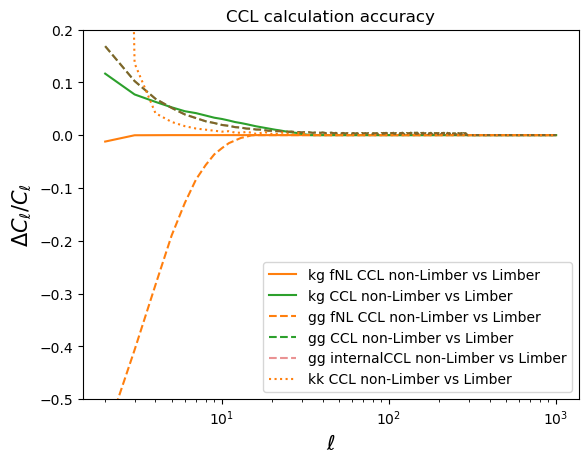

In [14]:
#pl.plot(ells,cls_th_fnl[1][2:]/cls_th_fnl_ccl[1][2:] -1,label='kg fNL CAMB T(k) vs CCL T(k)')
pl.plot(ells,cl_kgc_custom_fnl/cl_kgc_custom_fnl_lim -1,label='kg fNL CCL non-Limber vs Limber',color='C1')
pl.plot(ells,cl_kg_ccl/cl_kg_ccl_lim -1,label='kg CCL non-Limber vs Limber',color='C2')

#pl.plot(ells,cl_gc_custom_fnl/cl_gc_custom_fnl[2][2:] -1,color='C0',ls='--',label='gg fNL CAMB T(k) vs CCL T(k)')
pl.plot(ells,cl_gc_custom_fnl/cl_gc_custom_fnl_lim -1,color='C1',ls='--',label='gg fNL CCL non-Limber vs Limber')
pl.plot(ells,cl_gc_custom/cl_gc_custom_lim -1,color='C2',ls='--',label='gg CCL non-Limber vs Limber')
pl.plot(ells,cl_gg_ccl/cl_gg_ccl_lim -1,color='C3',ls='--',label='gg internalCCL non-Limber vs Limber',alpha=0.5)

pl.plot(ells,cl_kk_ccl/cl_kk_ccl_lim -1,color='C1',ls=':',label='kk CCL non-Limber vs Limber')

#pl.yscale('log')
pl.xscale('log')
pl.ylabel("$\\Delta C_\\ell/C_\\ell$",size=15)
pl.xlabel('$\\ell$',size=15)
pl.legend()
pl.title("CCL calculation accuracy")
pl.ylim(-0.5,0.2)
pl.show()

# CAMB vs CCL comparison

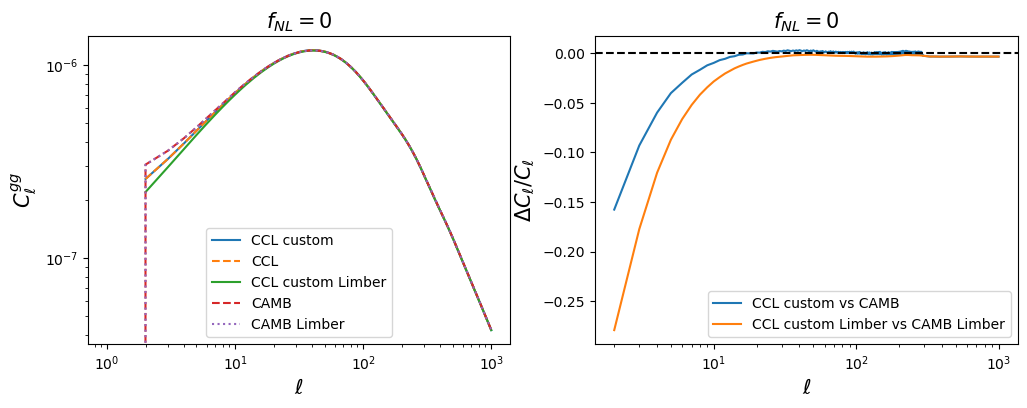

In [74]:
pl.figure(figsize=(12,4))
pl.subplot(121)
pl.loglog(ells,cl_gc_custom,label='CCL custom')
pl.loglog(ells,cl_gg_ccl,label='CCL',ls='--')
pl.loglog(ells,cl_gc_custom_lim,label='CCL custom Limber')
pl.loglog(cls_th[0],cls_th[2],ls='--',label='CAMB')
pl.loglog(cls_th[0],cls_th_lim[2],label='CAMB Limber',ls=':')
pl.legend()
pl.ylabel("$C_\\ell^{gg}$",size=15)
pl.xlabel("$\\ell$",size=15)
pl.title("$f_{NL}=0$",size=15)


pl.subplot(122)
pl.plot(ells,cl_gc_custom/cls_th[2][2:] -1,label='CCL custom vs CAMB')
pl.plot(ells,cl_gc_custom_lim/cls_th_lim[2][2:] -1,label='CCL custom Limber vs CAMB Limber')
pl.legend()
pl.ylabel("$\\Delta C_\\ell/C_\\ell$",size=15)
pl.xlabel("$\\ell$",size=15)
pl.title("$f_{NL}=0$",size=15)
pl.xscale('log')
pl.axhline(0,color='black',ls='--')
pl.show()

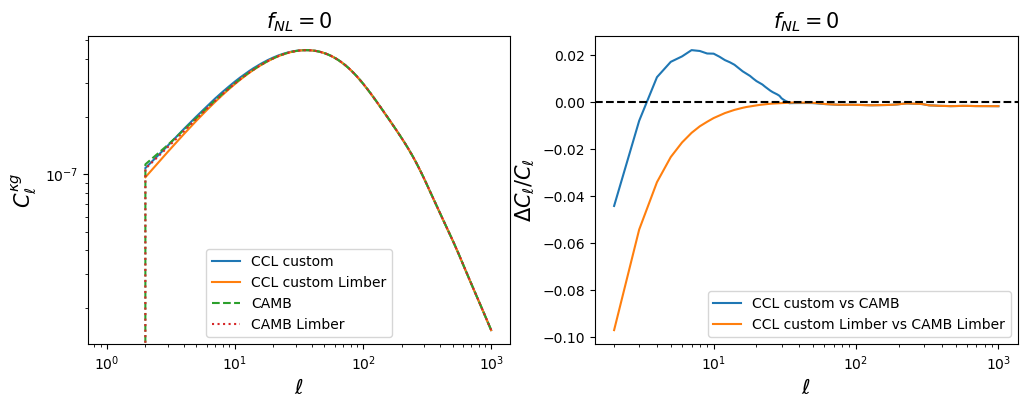

In [75]:
pl.figure(figsize=(12,4))
pl.subplot(121)
pl.loglog(ells,cl_kg_ccl,label='CCL custom')
pl.loglog(ells,cl_kg_ccl_lim,label='CCL custom Limber')
pl.loglog(cls_th_fnl[0],cls_th[1],ls='--',label='CAMB')
pl.loglog(cls_th_fnl[0],cls_th_lim[1],label='CAMB Limber',ls=':')
pl.legend()
pl.ylabel("$C_\\ell^{\\kappa g}$",size=15)
pl.xlabel("$\\ell$",size=15)
pl.title("$f_{NL}=%d$"%0,size=15)

pl.subplot(122)
pl.plot(ells,cl_kg_ccl/cls_th[1][2:] -1,label='CCL custom vs CAMB')
pl.plot(ells,cl_kg_ccl_lim/cls_th_lim[1][2:] -1,label='CCL custom Limber vs CAMB Limber')
pl.legend()
pl.ylabel("$\\Delta C_\\ell/C_\\ell$",size=15)
pl.xlabel("$\\ell$",size=15)
pl.title("$f_{NL}=0$",size=15)
pl.xscale('log')
pl.axhline(0,color='black',ls='--')
pl.show()

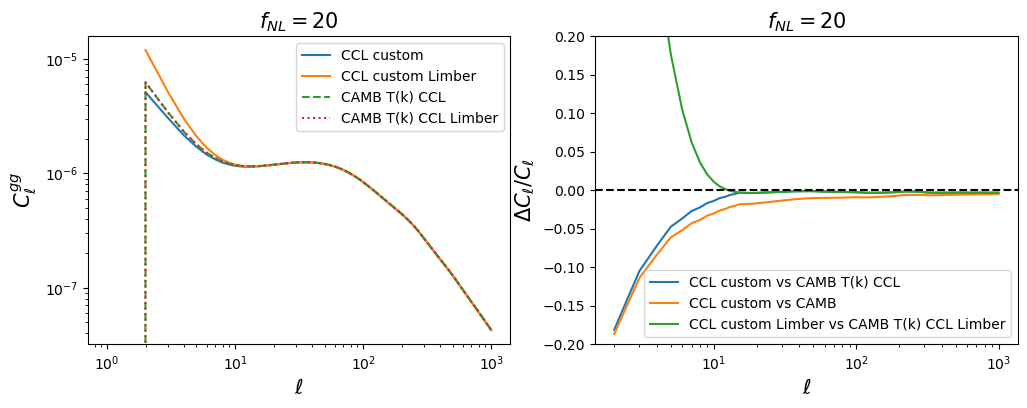

In [76]:
pl.figure(figsize=(12,4))
pl.subplot(121)

pl.loglog(ells,cl_gc_custom_fnl,label='CCL custom')
pl.loglog(ells,cl_gc_custom_fnl_lim,label='CCL custom Limber')
pl.loglog(cls_th_fnl[0],cls_th_fnl_ccl[2],ls='--',label='CAMB T(k) CCL')
pl.loglog(cls_th_fnl[0],cls_th_fnl_ccl_lim[2],label='CAMB T(k) CCL Limber',ls=':')
pl.legend()
pl.ylabel("$C_\\ell^{gg}$",size=15)
pl.xlabel("$\\ell$",size=15)
pl.title("$f_{NL}=%d$"%fNL,size=15)

pl.subplot(122)
pl.plot(ells,cl_gc_custom_fnl/cls_th_fnl_ccl[2][2:] -1,label='CCL custom vs CAMB T(k) CCL')
pl.plot(ells,cl_gc_custom_fnl/cls_th_fnl[2][2:] -1,label='CCL custom vs CAMB')
pl.plot(ells,cl_gc_custom_fnl_lim/cls_th_fnl_ccl[2][2:] -1,label='CCL custom Limber vs CAMB T(k) CCL Limber')
pl.legend()
pl.ylabel("$\\Delta C_\\ell/C_\\ell$",size=15)
pl.xlabel("$\\ell$",size=15)
pl.title("$f_{NL}=20$",size=15)
pl.xscale('log')
pl.ylim(-0.2,0.2)
pl.axhline(0,color='black',ls='--')
pl.show()

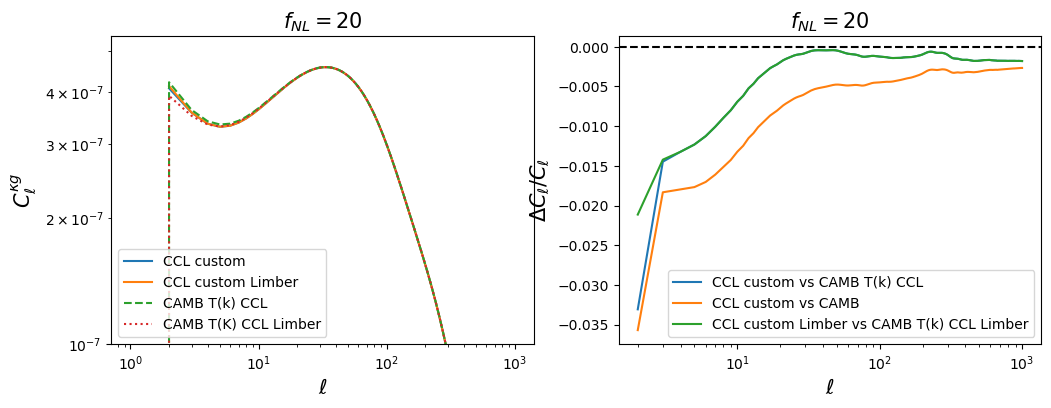

In [77]:
pl.figure(figsize=(12,4))
pl.subplot(121)

pl.loglog(ells,cl_kgc_custom_fnl,label='CCL custom')
pl.loglog(ells,cl_kgc_custom_fnl_lim,label='CCL custom Limber')
pl.loglog(cls_th[0],cls_th_fnl_ccl[1],ls='--',label='CAMB T(k) CCL')
pl.loglog(cls_th[0],cls_th_fnl_ccl_lim[1],label='CAMB T(K) CCL Limber',ls=':')
pl.legend()
pl.ylabel("$C_\\ell^{\\kappa g}$",size=15)
pl.xlabel("$\\ell$",size=15)
pl.ylim(1e-07,None)
pl.title("$f_{NL}=%d$"%fNL,size=15)

pl.subplot(122)
pl.plot(ells,cl_kgc_custom_fnl/cls_th_fnl_ccl[1][2:] -1,label='CCL custom vs CAMB T(k) CCL')
pl.plot(ells,cl_kgc_custom_fnl/cls_th_fnl[1][2:] -1,label='CCL custom vs CAMB ')
pl.plot(ells,cl_kgc_custom_fnl_lim/cls_th_fnl_ccl[1][2:] -1,label='CCL custom Limber vs CAMB T(k) CCL Limber')
pl.legend()
pl.ylabel("$\\Delta C_\\ell/C_\\ell$",size=15)
pl.xlabel("$\\ell$",size=15)
pl.title("$f_{NL}=20$",size=15)
pl.xscale('log')
pl.axhline(0,color='black',ls='--')
pl.show()

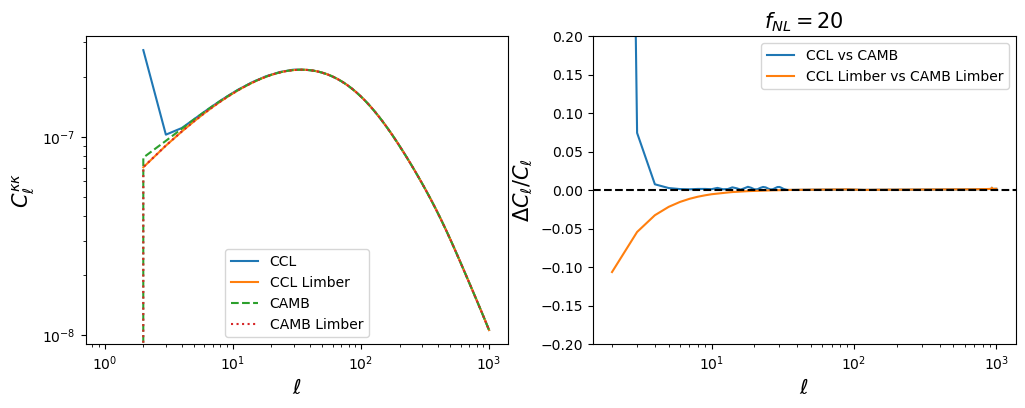

In [78]:
pl.figure(figsize=(12,4))
pl.subplot(121)

pl.loglog(ells,cl_kk_ccl,label='CCL')
pl.loglog(ells,cl_kk_ccl_lim,ls='-',label='CCL Limber')
pl.loglog(cls_th[0],cls_th[3][:1001],ls='--',label='CAMB')
pl.loglog(cls_th[0],cls_th_lim[3][:1001],ls=':',label='CAMB Limber')
pl.legend()
pl.ylabel("$C_\\ell^{\\kappa\\kappa}$",size=15)
pl.xlabel("$\\ell$",size=15)

pl.subplot(122)
pl.plot(ells,cl_kk_ccl/cls_th[3][2:] -1,label='CCL vs CAMB ')
pl.plot(ells,cl_kk_ccl_lim/cls_th[3][2:] -1,label='CCL Limber vs CAMB Limber')
pl.legend()
pl.ylabel("$\\Delta C_\\ell/C_\\ell$",size=15)
pl.xlabel("$\\ell$",size=15)
pl.title("$f_{NL}=20$",size=15)
pl.xscale('log')
pl.ylim(-0.2,0.2)
pl.axhline(0,color='black',ls='--')
pl.show()

In [21]:
#zs_p = dndz[0]#zs[zs<=dndz[0][-1]]
#ks_ccl = np.logspace(-6, 3, len(zs_p))
#pl.loglog(ks,Tk(ks))
#pl.loglog(ks,gc_custom.get_transfer(ks,1/1.5)[0]/gc_custom.get_transfer(ks,1/1.5)[0][0])
#pl.loglog(ks,gc_custom.get_transfer(ks,1/1.5)[1]/gc_custom.get_transfer(ks,1/1.5)[1][0])

In [22]:
cmbl

<pyccl.tracers.Tracer>
	num       kernel             transfer       prefac  bessel 
	 0  0x96714a13108a9390         None           1       -1   

In [23]:
gc_custom

<pyccl.tracers.Tracer>
	num       kernel             transfer       prefac  bessel 
	 0  0x2f1118f3f69ff41f  0xcf727ce51e699e7e    0       0    
	 1  0x2f1118f3f69ff41f  0x50a0f4f78636af5c    0       0    

In [26]:
cclg

<pyccl.tracers.NzTracer>
	num       kernel             transfer       prefac  bessel 
	 0  0x2f1118f3f69ff41f  0xcf727ce51e699e7e    0       0    

In [27]:
cosmo

<pyccl.cosmology.Cosmology>
	A_s     = 2.1052093313375065e-09
	Neff    = 3.044
	Omega_b = 0.0492071330589849
	Omega_c = 0.2619039780521262
	h       = 0.67
	n_s     = 0.9665
	extra_parameters =
	HASH_ACCURACY_PARAMS = 0x26062a923a152fa2